# Notebook to generate figure 1A of supplementary information
In this notebook we model the atom dynamics by a statistical process whose macroscopic observables are the loading rate $\Gamma_{\text{load}}$ and loss rate $\Gamma_{\text{loss}}$. For short enough time steps $dt$ the loading of a single atom is described by a Bernoulli trial $\mathcal{B}[1,p_{\text{load}}=\Gamma_{\text{load}} \ dt]$. The loss of single atom is described by a binomial process $\mathcal{B}[\tilde{N}_{\text{at}}(t-\ dt),p_{\text{loss}}=\Gamma_{\text{loss}} \ dt]$. 
The change of atom number at time $t$ is then given by $\Delta \tilde{N}(t) = \mathcal{B}[1,p_{\text{load}}] - \mathcal{B}[\tilde{N}_{\text{at}}(t-\ dt),p_{\text{loss}}]$. In the experiment the finite imaging time $\tau$ leads to an observed signal, that is the sum of the observed dynamics during this time. For simulation we divide the imaging time into a number of time steps $N_{\text{bins}}= \frac{\tau}{dt}$ on which we simulate the atom dynamics.

For the simulation we need the following paramters:


#### Experimental parameters
- imaging time $\tau$, total collection efficiency $\eta$, and the running time of the experiment $\text{real_time}$

#### Atom dynamic parameters
- photon scattering rate $\gamma_{\text{ph}}$, atom loading and loss rates $\Gamma_{\text{load}}$ and $\Gamma_{\text{loss}}$

#### Simulation paramters
- number of time traces simulated $N_{\text{traces}}$, number of possible atom events during exposure $N_{\text{bins}}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import pandas as pd

In [2]:
rng = np.random.default_rng()

In [3]:
PATH_fig = os.path.join("figures/")

In [4]:
# Experimental paramters
tau = 1500*1e-3 #imaging time [s] 
eta = 0.0002 #total photon collection and conversion efficiency 
real_time = 30 #time in s of time trace

# Atom dynamic parameters
gamma_ph = 28*10**6 #photon scattering rate [photons/atom/s]
Gamma_load = 16.54 #loading rate [atoms/s] 
Gamma_loss = 0.78 #loss rate [atoms/s]  

# Simulation parameters
N_bins = 100 #number of possible atom events during exposure time
N_traces = 1 # number of time traces to generate

In [5]:
dt = tau/N_bins #resulting time step of atom dynamics

p_load = Gamma_load*dt #resulting loading probability
p_loss = Gamma_loss*dt #resulting single atom loss probability

N_images = np.int(real_time/tau) #resulting number of images taken during "experiment"
N_tsteps = N_images*N_bins; #resulting number of time steps

In [6]:
print('loading rate: ', Gamma_load)
print('loading probability: ', p_load)
print('single atom loss probability: ', p_loss)

loading rate:  16.54
loading probability:  0.2481
single atom loss probability:  0.0117


## Simulate the atom dynamics
produce $N_{\text{traces}}$  timetraces

In [7]:
atom_time_traces = np.zeros((N_tsteps,N_traces), dtype=int)
p_load = np.full(N_traces,p_load)
p_loss = np.full(N_traces, p_loss)
for i in range(N_tsteps):
    n_load=rng.binomial(1, p=p_load)
    n_loss=rng.binomial(atom_time_traces[i-1],p_loss)
    atom_time_traces[i] = atom_time_traces[i-1]+n_load-n_loss;

## Simulate camera counts
To simulate camera counts we have to sum $N_{\text{bins}}$ points from $\text{atom_time_traces}$. This can be done by reshaping the 2D array to a 3D array and then summing along axis 1.

In [8]:
camera_counts = atom_time_traces
camera_counts = eta*gamma_ph*dt*camera_counts

## Compare true vs observed timetraces
to compare the true time traces with the observed ones we have to rescale the camera count arrays to the same length

In [9]:
rescaled_bins = 4*N_bins
rescaled_camera_counts = (1/rescaled_bins)*camera_counts.reshape(-1,rescaled_bins,atom_time_traces.shape[-1]).sum(axis=1)

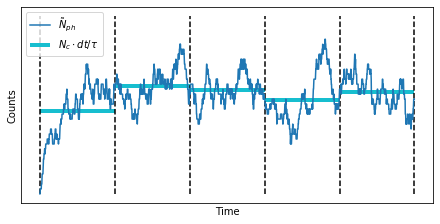

In [11]:
f, ax1 = plt.subplots(1,1,figsize=(6,3),constrained_layout = True)
ax1.plot(camera_counts[:,0],'-',color='C0', alpha=1.0,label='$ \\tilde{N}_{ph}$');
ax1.plot(np.arange(N_tsteps+1)[rescaled_bins::rescaled_bins],rescaled_camera_counts[:,0],'.',color='Orange', linewidth=2,alpha=0.009);
ax1.vlines(x=np.arange(N_tsteps+1)[::rescaled_bins],ymin=[0,*0*rescaled_camera_counts[:,0]],ymax=3e3,linestyles='dashed',color='k')
ax1.hlines(y=rescaled_camera_counts[:,0],xmin=np.arange(N_tsteps)[::rescaled_bins],xmax=np.arange(N_tsteps+1)[rescaled_bins::rescaled_bins],color='C9',linewidth=4,zorder=0,label='$N_c \cdot dt/\\tau$')
ax1.set_ylabel('Counts')
ax1.set_xlabel('Time')
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
ax1.legend();
my_file = 'Supplementary_Figure1_A.pdf'
f.savefig(os.path.join(PATH_fig, my_file)) 